<a href="https://colab.research.google.com/github/seungchaena/AI_SPARK_Challenge_2023/blob/main/Median_distance_based_KDE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# The 4th AI SPARK Challenge in 2023 Reserach and Development Zone

In [ ]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import RobustScaler
from sklearn.neighbors import KernelDensity

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
train = pd.read_csv('/content/drive/MyDrive/AI_factory AI SPARK/train_data.csv') # (2463, 8)
test = pd.read_csv('/content/drive/MyDrive/AI_factory AI SPARK/test_data.csv') # (7389, 8)


In [ ]:
train.isna().sum().sum()

0

In [ ]:
train.drop(columns='type', axis=1).describe()

,air_inflow,air_end_temp,out_pressure,motor_current,motor_rpm,motor_temp,motor_vibe
count,2463.000000,2463.000000,2.463000e+03,2463.000000,2463.000000,2463.000000,2463.000000
mean,2.128843,49.001137,7.000000e-01,27.490715,2372.576939,65.766707,3.452972
std,1.202328,8.725091,1.110448e-16,13.604597,687.870774,7.797152,1.576386
min,0.330000,32.030000,7.000000e-01,5.340000,1201.000000,50.360000,1.970000
25%,1.280000,41.600000,7.000000e-01,17.110000,1784.500000,59.150000,2.880000
50%,1.960000,48.980000,7.000000e-01,25.850000,2358.000000,65.640000,3.260000
75%,2.820000,56.355000,7.000000e-01,36.000000,2971.000000,72.275000,3.730000
max,6.220000,64.960000,7.000000e-01,72.000000,3564.000000,80.520000,21.870000


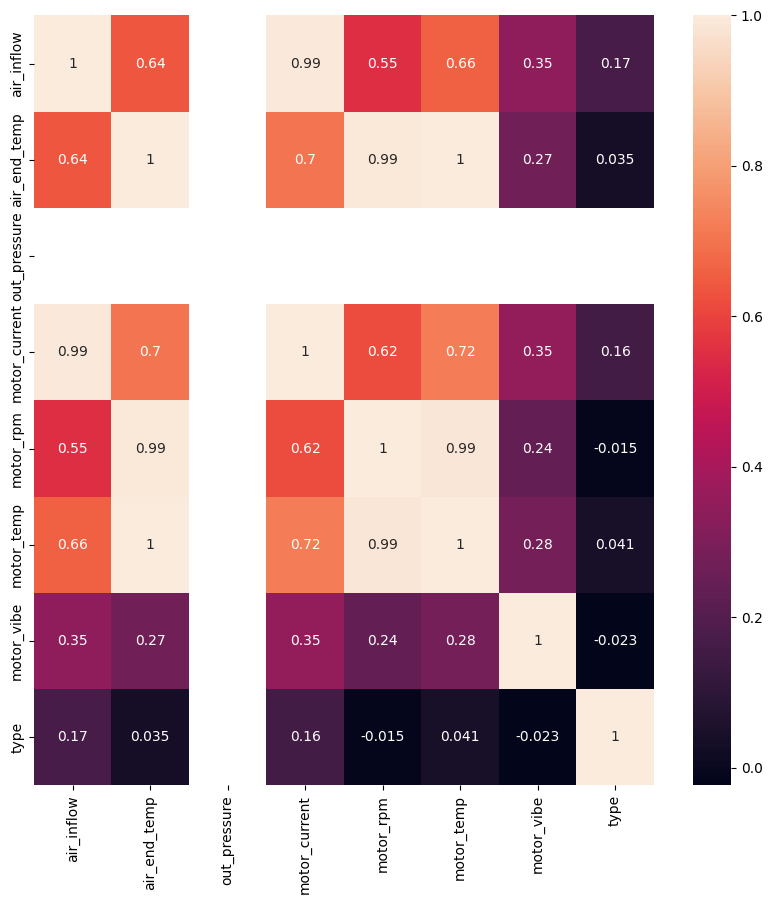

In [ ]:
fig, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(train.corr(), annot=True);

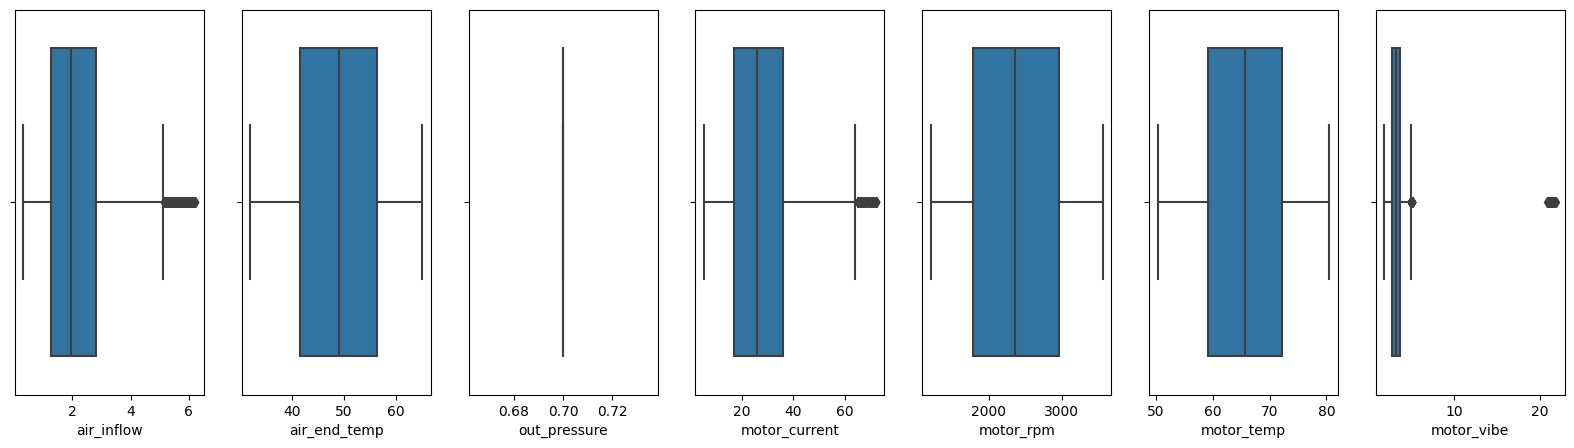

In [ ]:
sub_train = train[['air_inflow', 'air_end_temp', 'out_pressure', 'motor_current', 'motor_rpm', 'motor_temp', 'motor_vibe']]

fig, axs = plt.subplots(ncols = 7, figsize = (20, 5))

for i, col in enumerate(sub_train):
    sns.boxplot(x=sub_train[col], ax=axs[i])

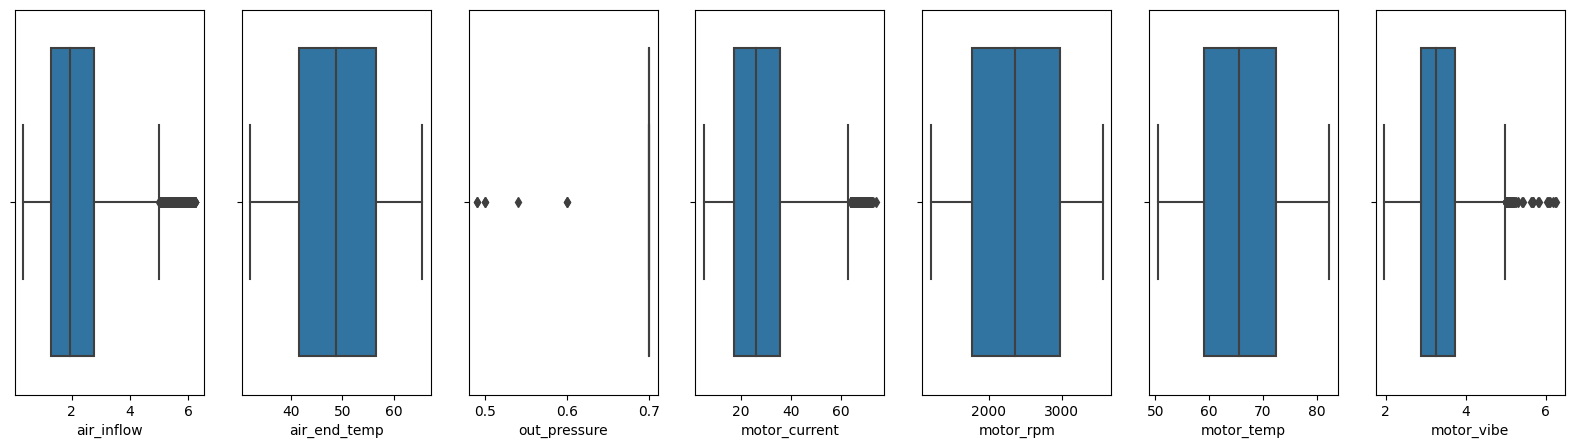

In [ ]:
sub_test = test[['air_inflow', 'air_end_temp', 'out_pressure', 'motor_current', 'motor_rpm', 'motor_temp', 'motor_vibe']]

fig, axs = plt.subplots(ncols = 7, figsize = (20, 5))

for i, col in enumerate(sub_test):
    sns.boxplot(x=sub_test[col], ax=axs[i])

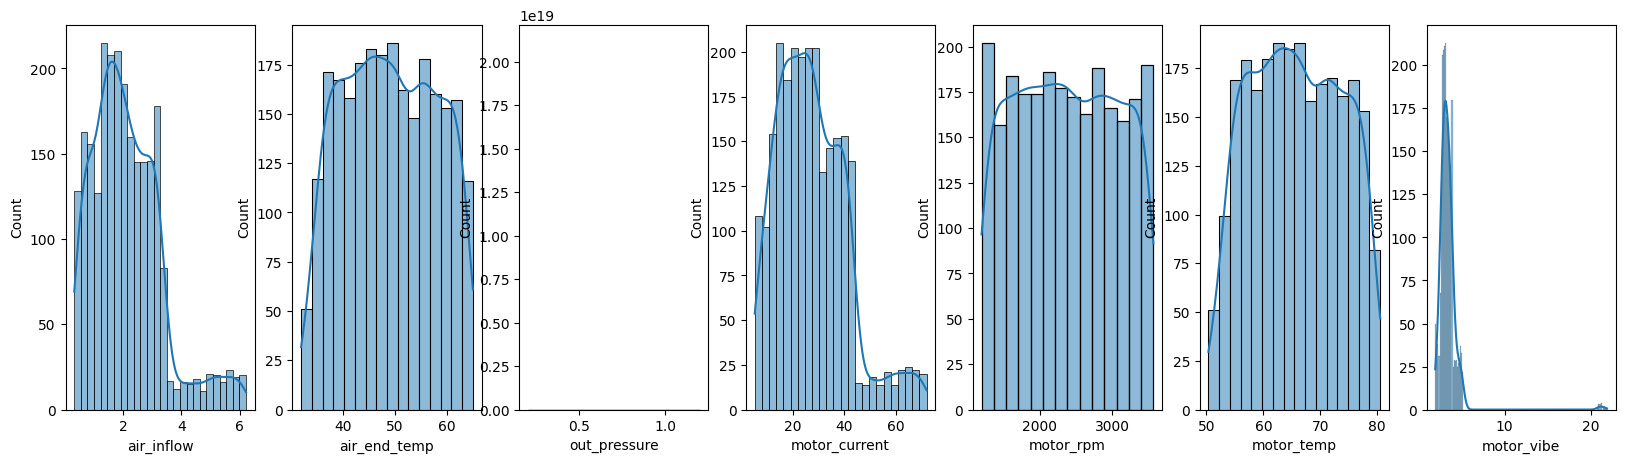

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=7, figsize=(20, 5))

for i, col in enumerate(sub_train.columns):
    sns.histplot(sub_train[col], kde=True, ax=ax[i])

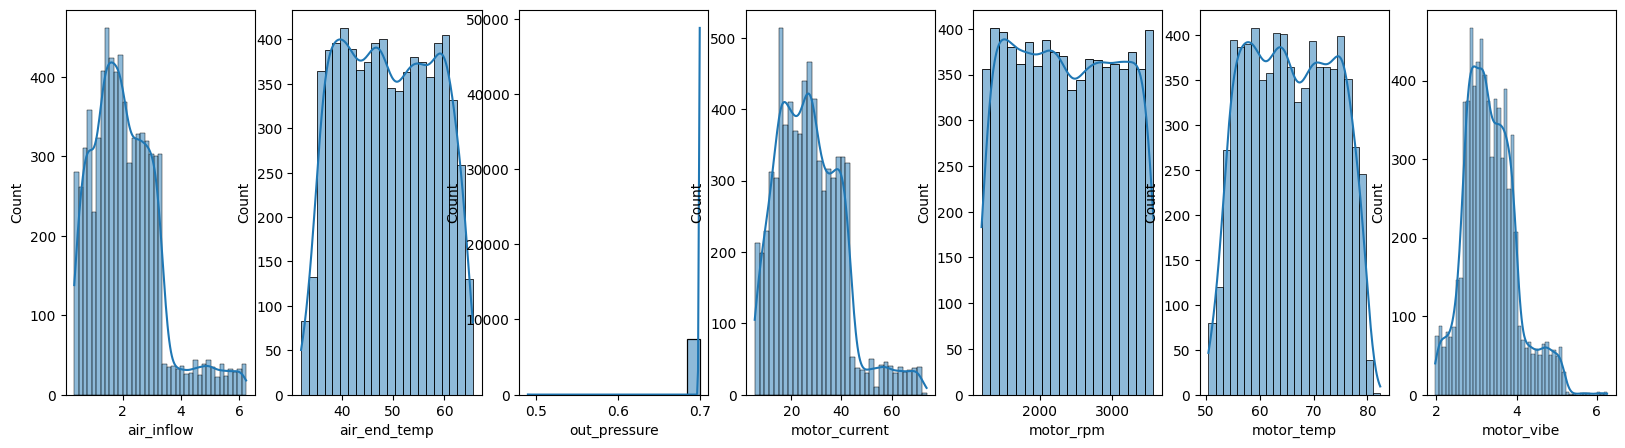

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=7, figsize=(20, 5))

for i, col in enumerate(sub_test.columns):
    sns.histplot(sub_test[col], kde=True, ax=ax[i])

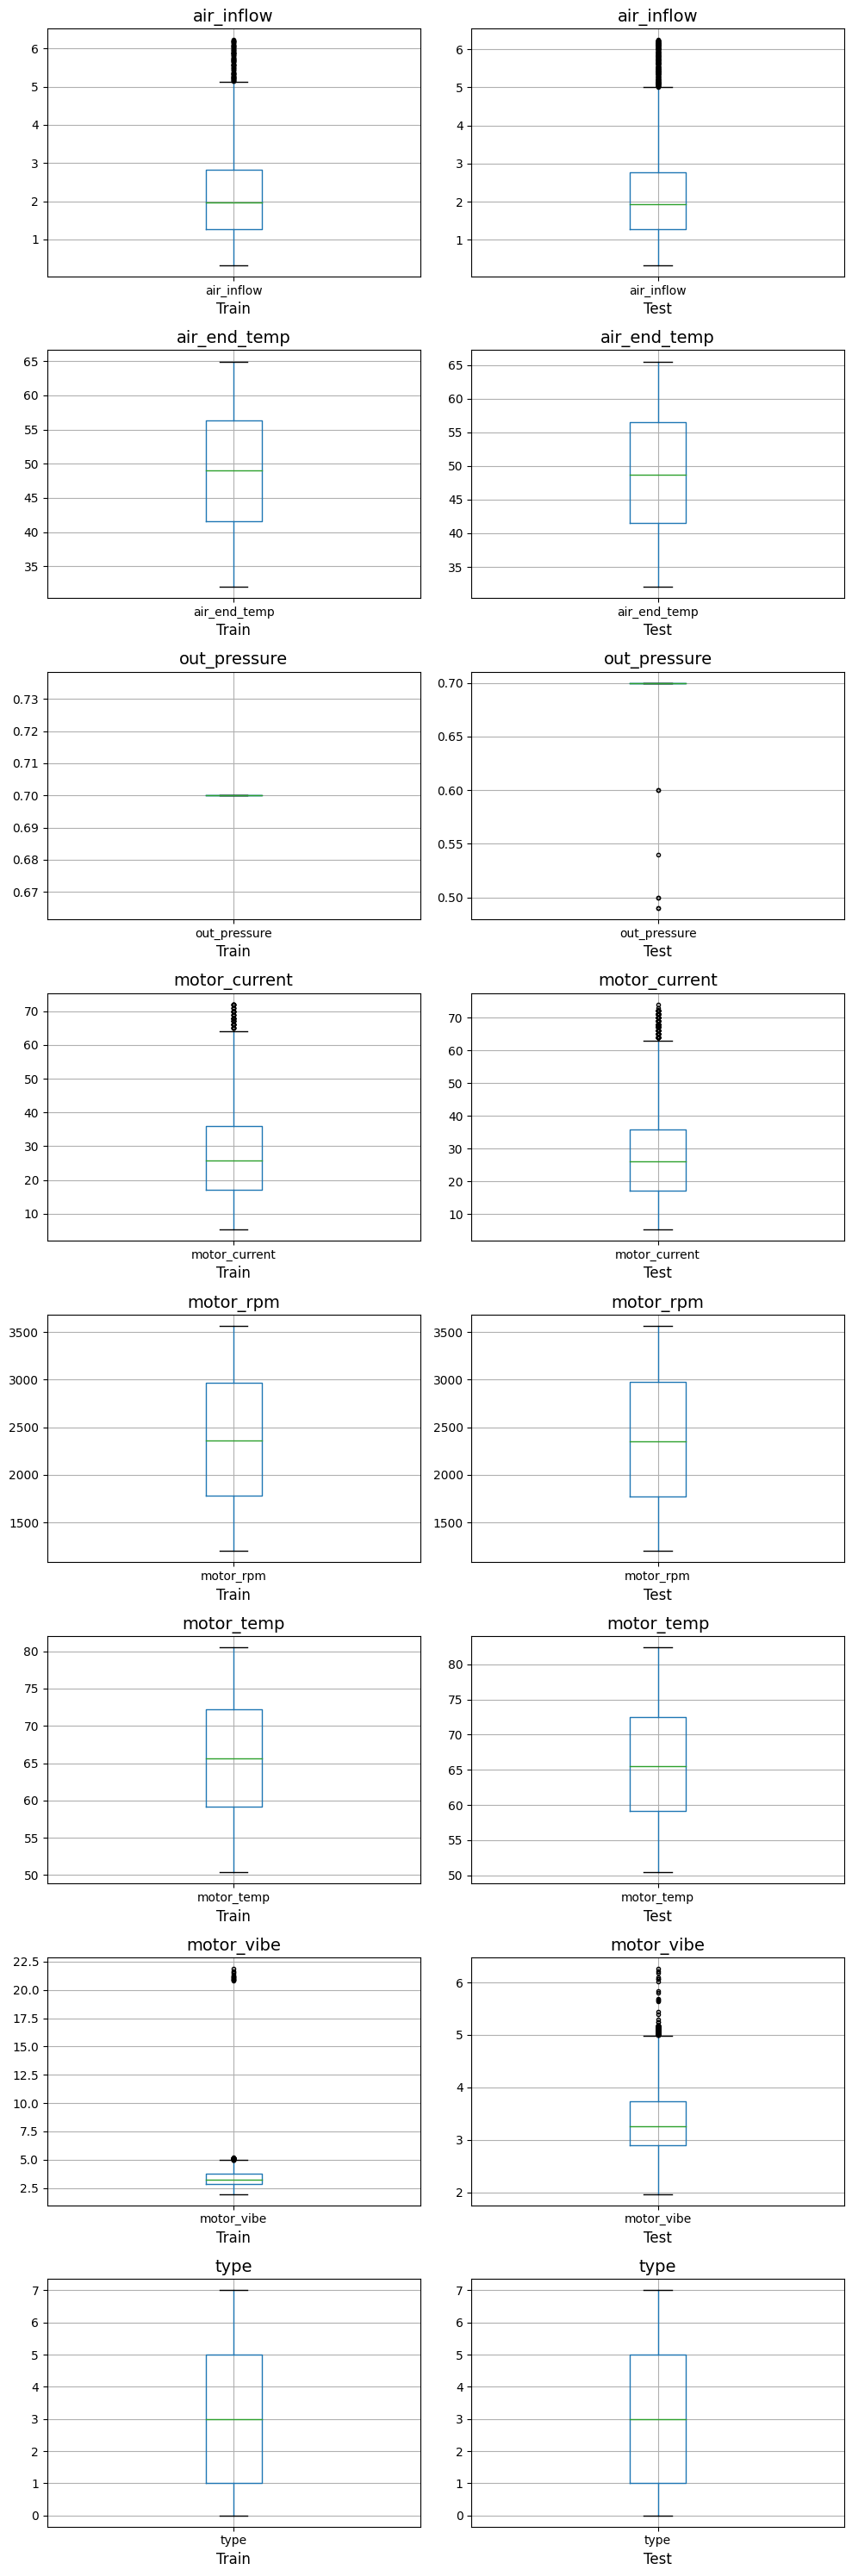

In [ ]:
fig, axes = plt.subplots(nrows=8, ncols=2, figsize=(10, 30))

for i, column in enumerate(train.columns):
    train.boxplot(column=column, ax=axes[i][0], sym='.')
    test.boxplot(column=column, ax=axes[i][1], sym='.')
    axes[i][0].set_title(column, fontsize=14)
    axes[i][1].set_title(column, fontsize=14)
    axes[i][0].set_xlabel('Train', fontsize=12)
    axes[i][1].set_xlabel('Test', fontsize=12)
    axes[i][0].set_ylabel('')
    axes[i][1].set_ylabel('')
plt.tight_layout()
plt.show()

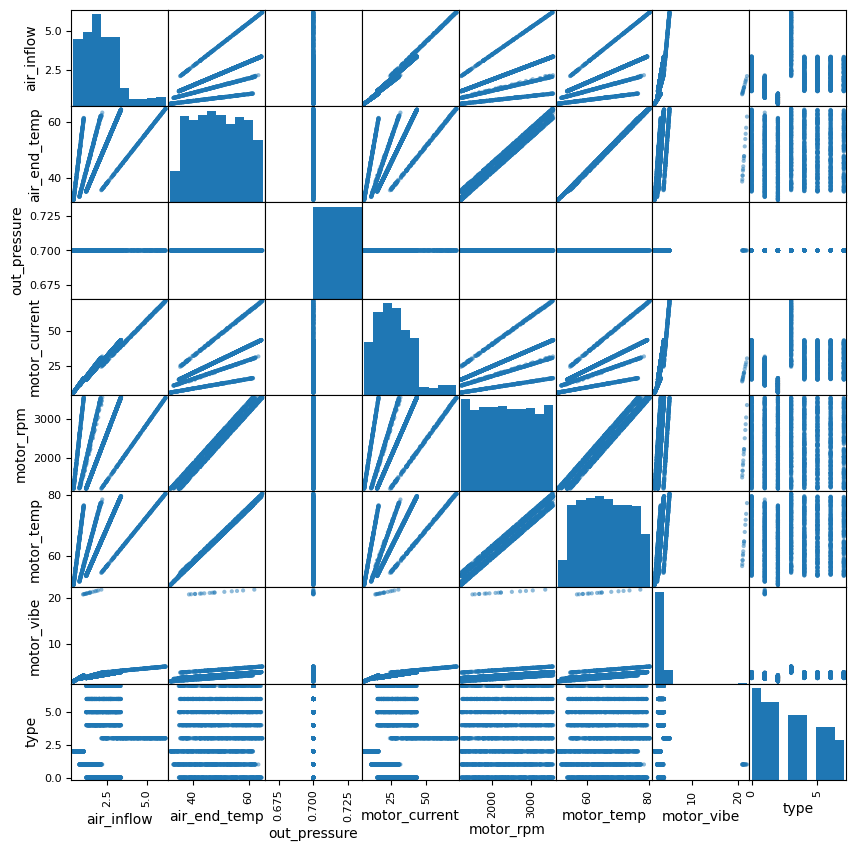

In [ ]:
pd.plotting.scatter_matrix(train, figsize=(10,10))
plt.show();

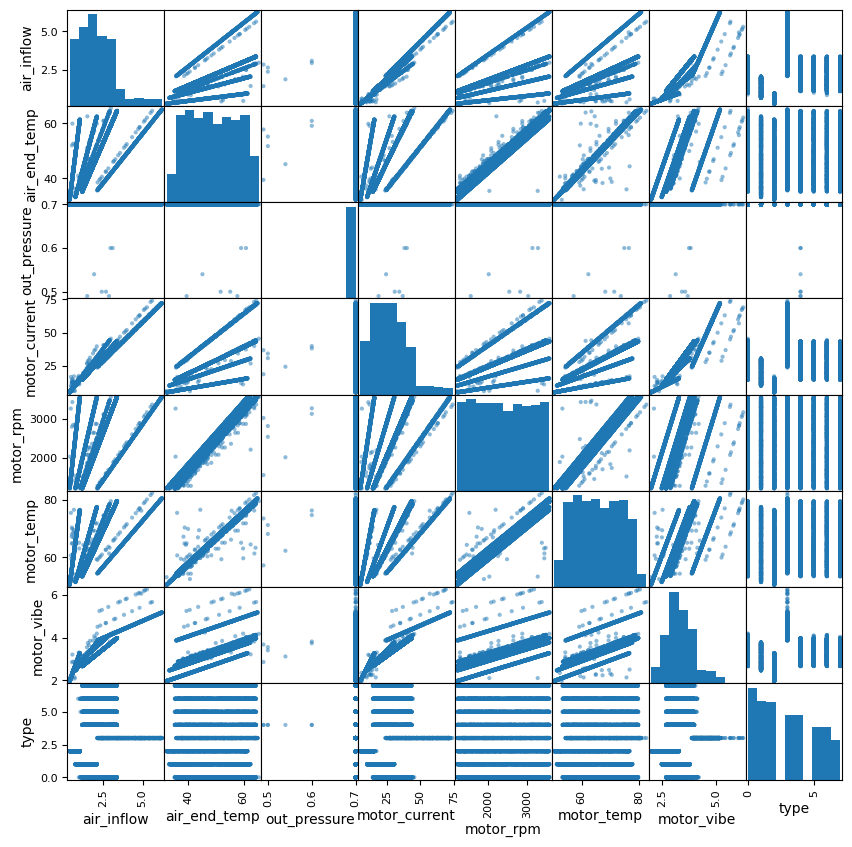

In [ ]:
pd.plotting.scatter_matrix(test, figsize=(10,10))
plt.show()

# Approach Method(Idea)

주어진 문제는 test data의 type의 정보가 없으며(제출을 통한 확인 외 불가)  
training data는 normal한 데이터로 구성되어 있고, test data는 normal + abnrmal한 데이터로 구성된  
일반적인 비지도학습 기반의 anomaly detection 문제이다.

---
- 두 데이터의 전체적인 분포를 다각도에서 확인해보면 두 데이터에서 두드러치는 차이를 확인할 수 있다. (histplot/scatter matrix등) 
- 그 중 scatter matrix에서 두드러지는 차이점으로는 test data가 상대적으로 지저분한 분포를 갖는다는 것이다.
- 이러한 차이는 "문제에서 명시된 test data의 특성 중, abnormal한 데이터분포가 아닐까?"라는 가정을 하였다.  
- 이러한 가정이 진실인지 확인하기 위해서는 주어진 두 데이터를 기정에 맞게 재구성하는 과정이 필요하다고 판단하였고,  
가정에 대한 데이터의 특징을 반영하기 위해 "모든 데이터 포인트 간 거리"를 계산하여 접근하였다.
- 또한 재구성된 데이터로부터 밀도를 추정하여 학습하기위해 Kernel Density Estimation(KDE)의 방식으로 학습하기로 결정하였다.
---

# Experiment

## Procedure
0. Creation of derived variables.

1. Modification of training data and test data  
: 가정에 대한 데이터 특징 반영을 위해 "거리"를 계산하기로 하였으며,  
데이터 포인트간 거리를 계산하기 위해서는 기준값을 설정하는 과정이 요구되었는데  
나는 그 중 "중앙값"을 선택하였다.  
이유는 중앙값은 데이터의 중심 경향성을 나타내는 척도로 Robustness하다는 성질을 갖기 때문이다.

2. Scailing  
: 두 데이터의 재구성하고 나면 스케일이 많이 차이나는것을 확인할 수 있는데, 이는 특성간 비교를 어렵게 만드므로 스케일링을 진행하였다.  
마찬가지로 데이터 스케일링을 진행하는 방법으로는 다양한 방법이 있지만 나는 그중에서 "RobustScailing"을 진행하였다.  
이유는 마찬가지로 Robustness하다는 성질을 갖기 때문이다.
3. Kernel Density Estimation

In [ ]:
# 0. Creation of derived variables
train['air_density'] = (train['out_pressure'] * 144) / (53.3 * (train['air_end_temp'] + 273.15))
test['air_density'] = (test['out_pressure'] * 144) / (53.3 * (test['air_end_temp'] + 273.15))

In [ ]:
train = train[train['motor_vibe'] < 20].drop(columns='type')
test = test.drop(columns='type')

train = train[['air_inflow', 'air_end_temp', 'out_pressure', 'motor_current', 'motor_rpm', 'motor_temp', 'motor_vibe','air_density']]
test = test[['air_inflow', 'air_end_temp', 'out_pressure', 'motor_current', 'motor_rpm', 'motor_temp', 'motor_vibe','air_density']]

In [ ]:
# 1. Modification of training data and test data
train_median = train.median()
test_median = test.median()
train_distance = train - train_median
test_distance = test - test_median

In [ ]:
# 2. Scailing
scaler = RobustScaler()
scaled_train = scaler.fit_transform(train_distance)
scaled_train = pd.DataFrame(scaled_train, columns=train.columns, index=train.index) # 인덱스유지
scaled_test = scaler.transform(test_distance)
scaled_test = pd.DataFrame(scaled_test, columns=test.columns, index=test.index) # 인덱스유지

scaled_train = pd.DataFrame(scaled_train, columns=['air_inflow', 'air_end_temp', 'out_pressure', 'motor_current', 'motor_rpm', 'motor_temp', 'motor_vibe','air_density'])
scaled_test = pd.DataFrame(scaled_test, columns=['air_inflow', 'air_end_temp', 'out_pressure', 'motor_current', 'motor_rpm', 'motor_temp', 'motor_vibe','air_density'])

In [ ]:
scaled_train.head()

,air_inflow,air_end_temp,out_pressure,motor_current,motor_rpm,motor_temp,motor_vibe,air_density
0,-0.238710,-0.540595,0.0,-0.286697,-0.574800,-0.534195,-0.380952,0.554053
1,0.651613,0.696211,0.0,0.658556,0.657396,0.699848,0.595238,-0.674306
2,-0.032258,-0.250338,0.0,-0.064533,-0.285714,-0.244681,-0.154762,0.253114
3,0.264516,0.158322,0.0,0.247554,0.121365,0.162614,0.166667,-0.157098
4,-0.038710,-0.255751,0.0,-0.068765,-0.290771,-0.250000,-0.154762,0.258651


In [ ]:
scaled_test.head()

,air_inflow,air_end_temp,out_pressure,motor_current,motor_rpm,motor_temp,motor_vibe,air_density
0,0.367742,0.305819,0.0,0.336948,0.258744,0.308511,0.261905,-0.301856
1,0.464516,0.438430,0.0,0.437979,0.391066,0.440729,0.369048,-0.430167
2,-0.141935,-0.407307,0.0,-0.208410,-0.451749,-0.403495,-0.297619,0.415444
3,0.167742,0.026387,0.0,0.123248,-0.019385,0.029635,0.047619,-0.026379
4,0.077419,-0.100135,0.0,0.026448,-0.145807,-0.097264,-0.059524,0.100689


In [ ]:
# 3. Grid search for Kernel Density Estimation
kde = KernelDensity()
grid = {'kernel': ['gaussian', 'tophat', 'epanechnikov', 'exponential', 'linear'],
        'bandwidth': np.arange(0.01, 1.1, 0.01)}

search = GridSearchCV(kde, param_grid=grid, cv=5, n_jobs=-1)
search.fit(scaled_train)
best_parameters = search.best_params_

In [ ]:
# 3. Training for  Kernel Density Estimation
kde = KernelDensity(**best_parameters).fit(scaled_train)
log_densities = kde.score_samples(scaled_test)
threshold = np.percentile(log_densities, 4.61)
outlier_indices = np.where(log_densities < threshold)[0]

print(len(outlier_indices))

341


In [ ]:
submission = pd.read_csv('/content/drive/MyDrive/AI_factory AI SPARK/test_data.csv')
submission['label'] = 0
submission.iloc[outlier_indices, submission.columns.get_loc('label')] = 1
submission = submission[['type', 'label']]

In [ ]:
submission['label'].value_counts()

0    7048
1     341
Name: label, dtype: int64

In [ ]:
submission.to_csv('/content/drive/MyDrive/AI_factory AI SPARK/submission.csv', index=False)

# Result

해당 접근 방식은 주어진 데이터로 부터 식별되는 데이터 특징을 고려하여 접근할 수 있는 방식이였으며,  
가정이 단순하고 직관점임에도 불구하고 Final score(macro f1-score): 0.9538864792의 우수한 점수를 기록할 수 있었다.

# Shortcomings
- 본 대회에서는 type(설비타입)에 대해 각 다른 특징을 갖는 다는 내용이 명시되어있지만,  
이 접근에서는 이를 고려하지 않은체 분석을 시도하였다.  
이는 좀 더 개선될 수 있는 여지가 있을것이라고 판단된다.

- 이 접근방법에서는 데이터 포인트 간 거리 계산의 기준척도로 중앙값을 사용하였다.  
이는 우수한 성능을 보여주었지만, 전체적인 데이터의 이상치를 탐지할 수는 없었다.  
이는 기준척도를 무게중심으로 바꾸어 global하고 local한 이상치까지 학습하여 더욱 조밀한 접근이 가능할 것으로 예상된다.